#### Initial Data Loading and Cleaning

In [ ]:
### Cleaning up data ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/AirQualityUCI.csv', sep=';')

# Create timestamps
df.insert(0, 'Timestamp', pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S'))

# Drop useless columns
df = df.drop(['Unnamed: 15', 'Unnamed: 16', 'Date', 'Time'], axis=1)

# Columns to floats
for col in df.columns.drop('Timestamp'):
    df[col] = df[col].map(lambda x: float(str(x).replace(',', '.')))
    
# Add NaNs instead of 200
df = df.replace(-200, np.nan)

# Remove useless columns at end
df = df.loc[~pd.isnull(df['Timestamp']), :]

# Nice alternative dataframe with timestamps as index
df_ts = df.set_index('Timestamp', drop=True)

df.to_excel('output_data/cleaned.xlsx')

#### Exploratory Data Analysis

In [ ]:
### Basic Data Properties - Missing Values ###

# Check no missing timestamps
expected_timestamps = pd.date_range(start=df['Timestamp'].min(), end=df['Timestamp'].max(), freq='1h')
missing_timestamps = expected_timestamps.difference(df['Timestamp'])
print(missing_timestamps) # empty

# What happens to missing timestamps if drop na. Omit the column which is all NA after a while
dropts = df.drop(['NMHC(GT)'], axis=1).dropna()['Timestamp']
drop_expected_timestamps = pd.date_range(start=dropts.min(), end=dropts.max(), freq='1h')
drop_missing_timestamps = expected_timestamps.difference(dropts)
print(len(drop_missing_timestamps), len(df['Timestamp'])) # 2k cols -> quarter of data

# From examining the excel file, it seems that the standard situation for 
# missing data is a measurement cutting out for a continuous series of hours (often exactly 24 or 48 hours)
# - perhaps sensors were turned off

# basic summaries, mainly for missing values
print(df.describe())
print("Percentage of missing values:\n", (df.isna().sum() / len(df) * 100).round(2))
# data starts at 2004-03. Ends at 2005-04 - very close to one year.
# All the PT sensors have similar standard deviations ranging from 200 to 400
# The sensor columns all have 8991 non NaN values - very rarely cut out, and when they do its all at the same time. I think T, RH, AH also cut out at exactly the same time
# Ground truth colums have around 7.5k non NaN values for all of them except NMHC which cuts out after about 1000 measurements.
# Missing value percentages: 4% for the 8991 cols, 17% consistently for GT columns except for NMHC (90%)
plt.figure()
(df_ts.isna().mean() * 100).plot(kind='bar')
plt.ylabel('% missing')
plt.title('Missing value percentage by each variable')
plt.tight_layout()
plt.show()

# Plots of missing values over time
day_miss_counts = df_ts.resample('3D').apply(lambda x: x.isna().sum())
plt = day_miss_counts.plot(kind='line', figsize=(12,24), subplots=True)

# Takeaways
# PT08 + meteorogical sensors go missing at exactly the same time                                 
# NOx and NO2 GT stations go missing at exactly same time - seem to be same device.
# CO(GT) also goes missing often
# The spikes are to at least 20. This means that when things go missing it is usually
# for a long period of time. If pollutant measurements change significantly throughout
# the day, imputing using just the mean is probably a bad idea over such long timespans.
# Some other approach would have to be used.
# Ground truth station have frequent spikes up to 60, indicating entire 3 day sections
# missing. Will have to think about how to impute

# If we decide to drop sections with too many missing values, we will have to think about 
# how our model handles jumps in time. Need this when developing our time features




In [ ]:
### Univariate Time Series Analysis ###
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

## Day averages over time and Rolling Windows over Time
day_avgs = df_ts.resample('10D').apply(lambda x: x.mean())
dplt = day_avgs.plot(kind='line', figsize=(12,36), subplots=True)

df_rolling = df_ts.rolling('D', min_periods=12).mean()
fig, ax = plt.subplots(figsize=(15,25))
dplt = df_rolling.plot(kind='line', figsize=(12,36), ax=ax, subplots=True)

## Correspondence of normalised sensor and ground truth readings
df_normalised = df_ts.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_normalised_resampled = df_normalised.resample('1D').apply(lambda x: x.mean())

sensor_plots_fig, sensor_plots_ax = plt.subplots(4, 1, figsize=(20,15))
for cols, ax in zip([
    ['CO(GT)', 'PT08.S1(CO)'],
    ['NMHC(GT)', 'PT08.S2(NMHC)'],
    ['NOx(GT)', 'PT08.S3(NOx)'],
    ['NO2(GT)', 'PT08.S4(NO2)'],
], sensor_plots_ax):
    df_normalised_resampled[cols].plot(kind='line', ax=ax)
    
## Histograms ##
fig, ax = plt.subplots(figsize=(15,15), constrained_layout=True)
df_ts.hist(bins=50, ax=ax)



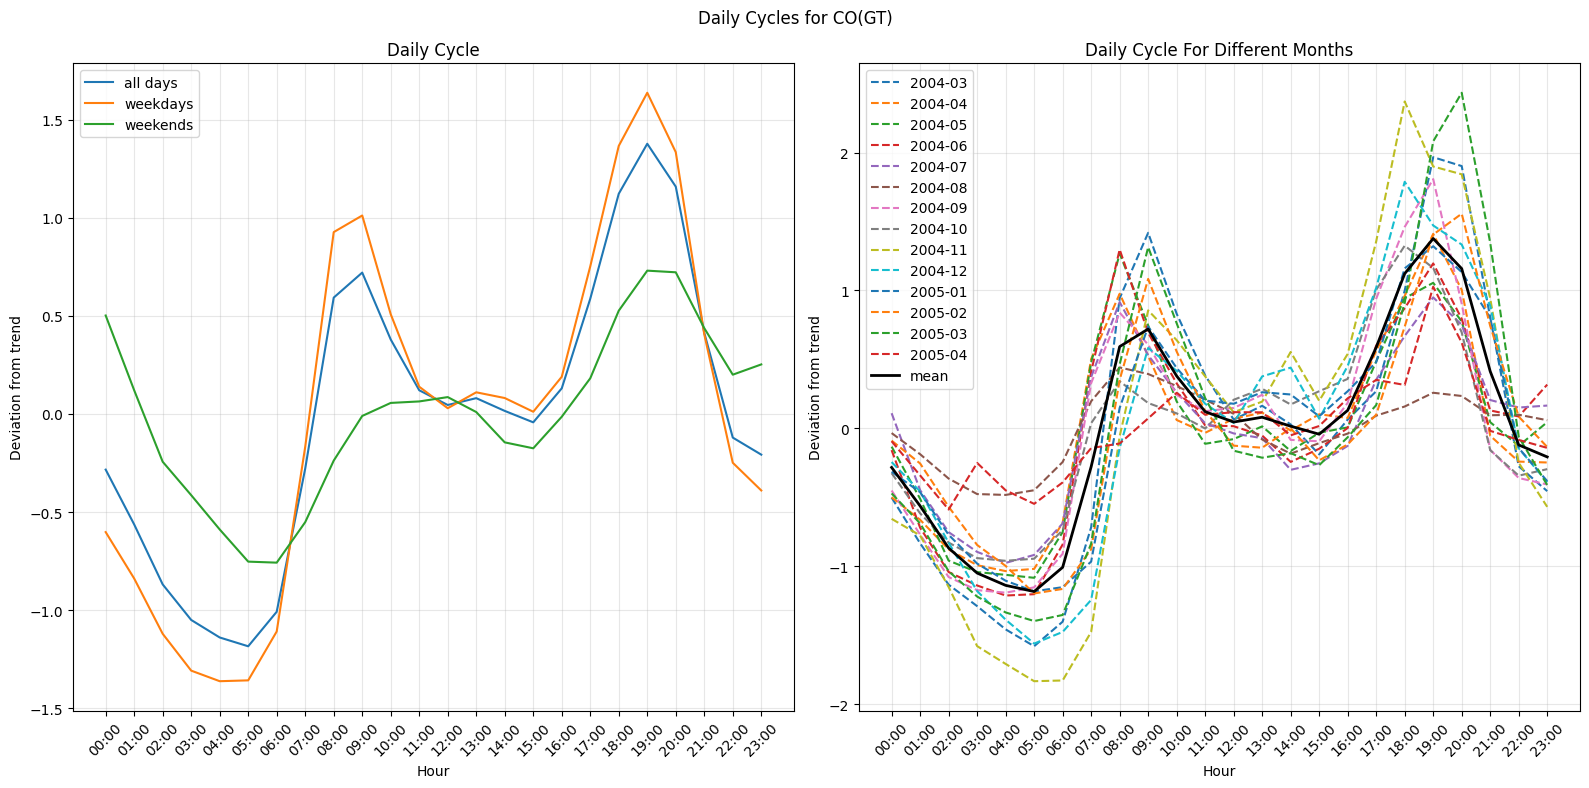

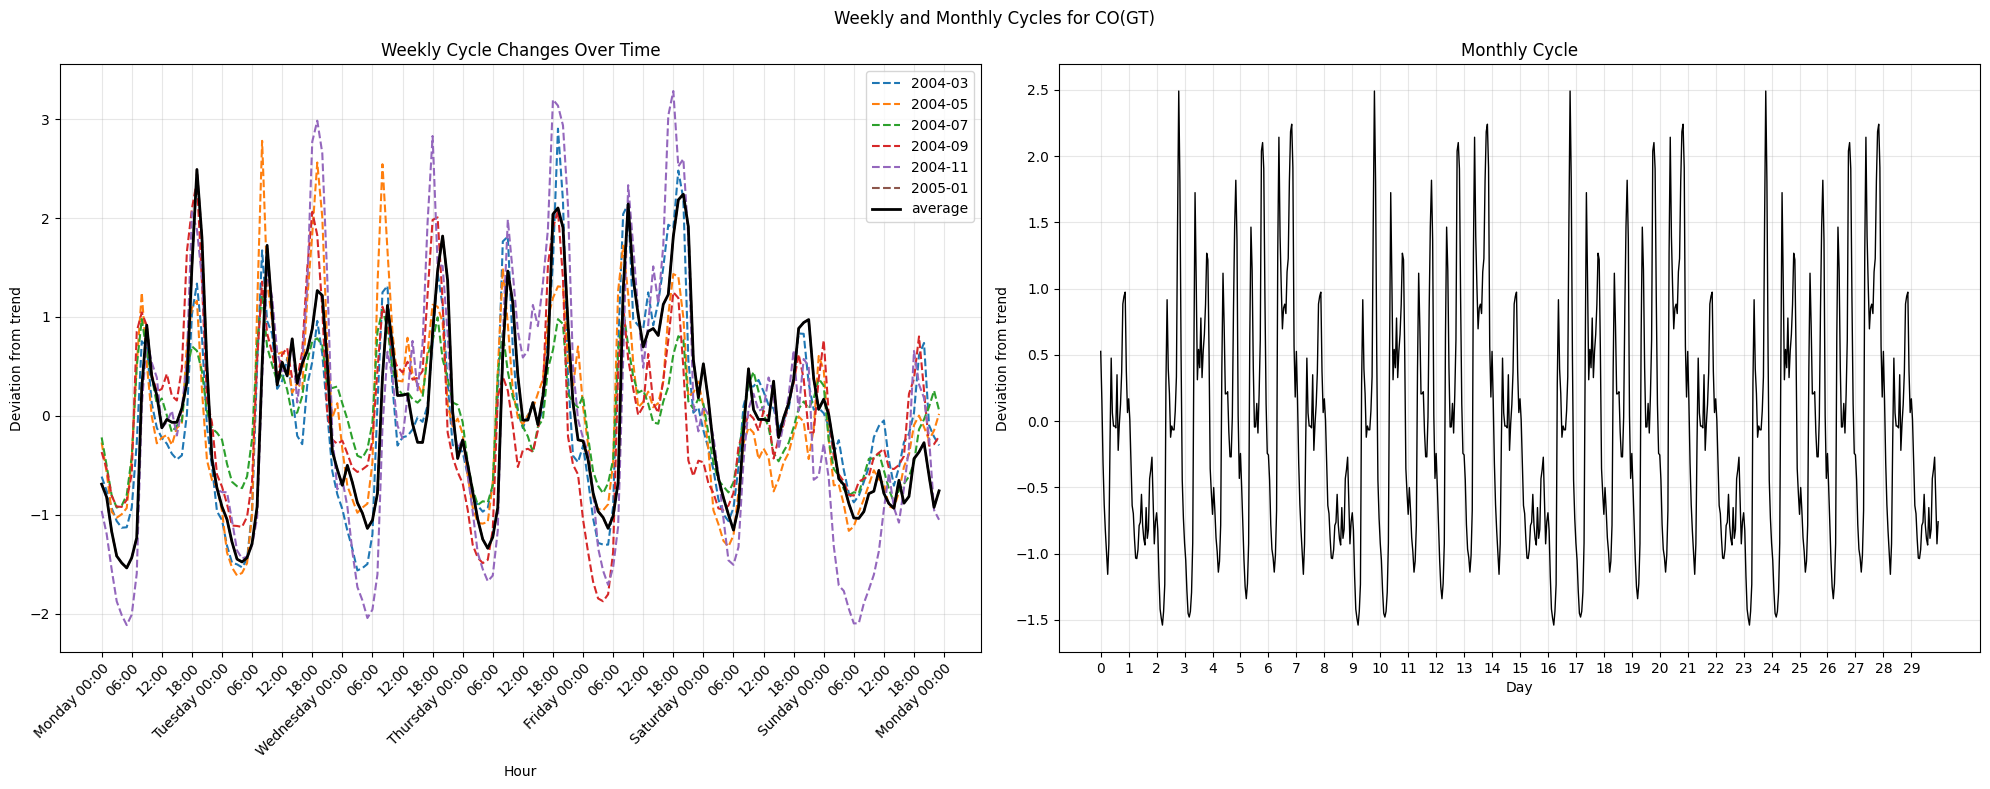

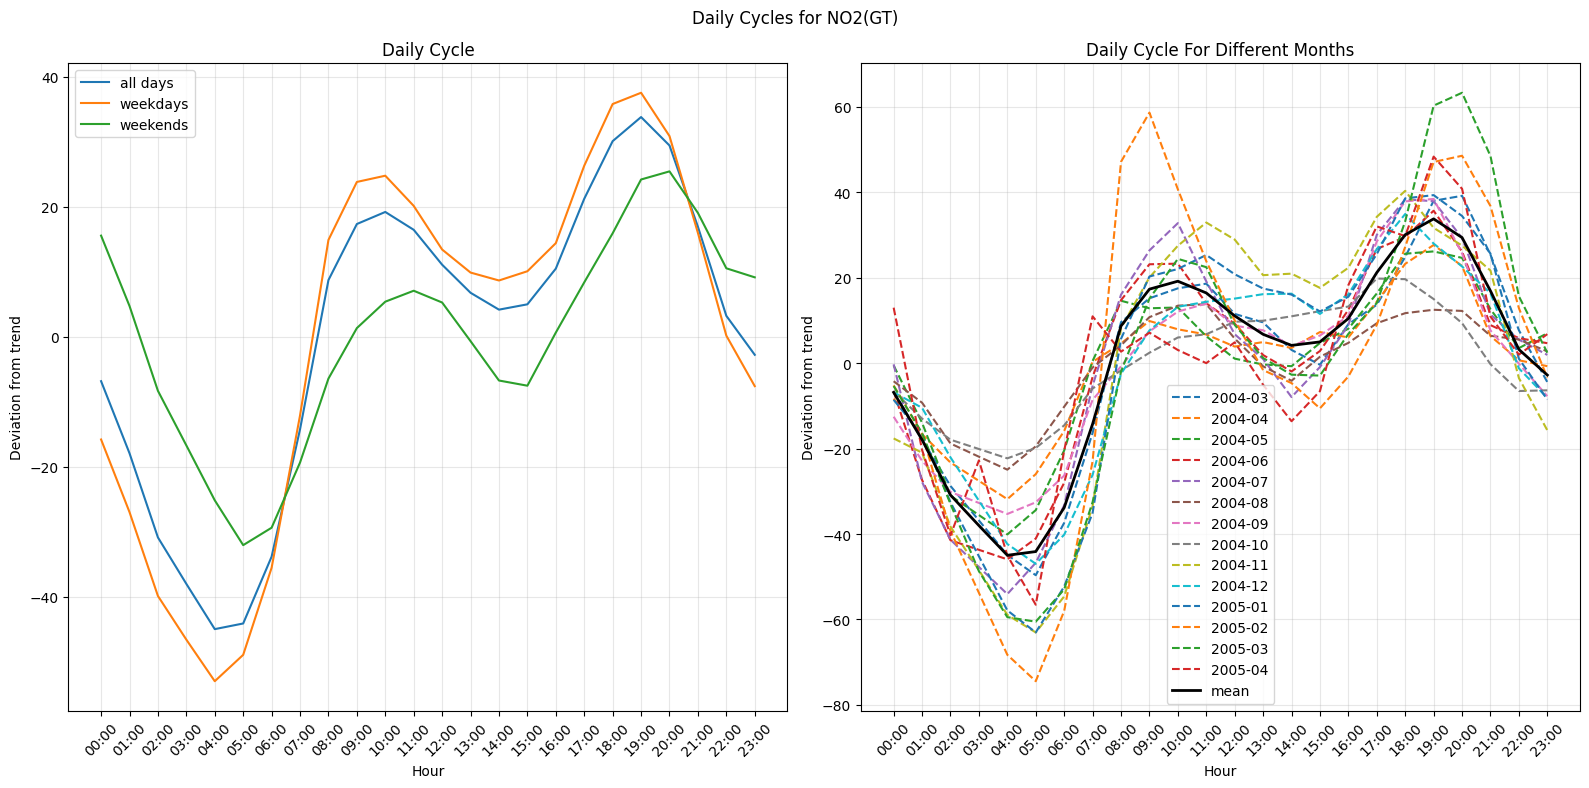

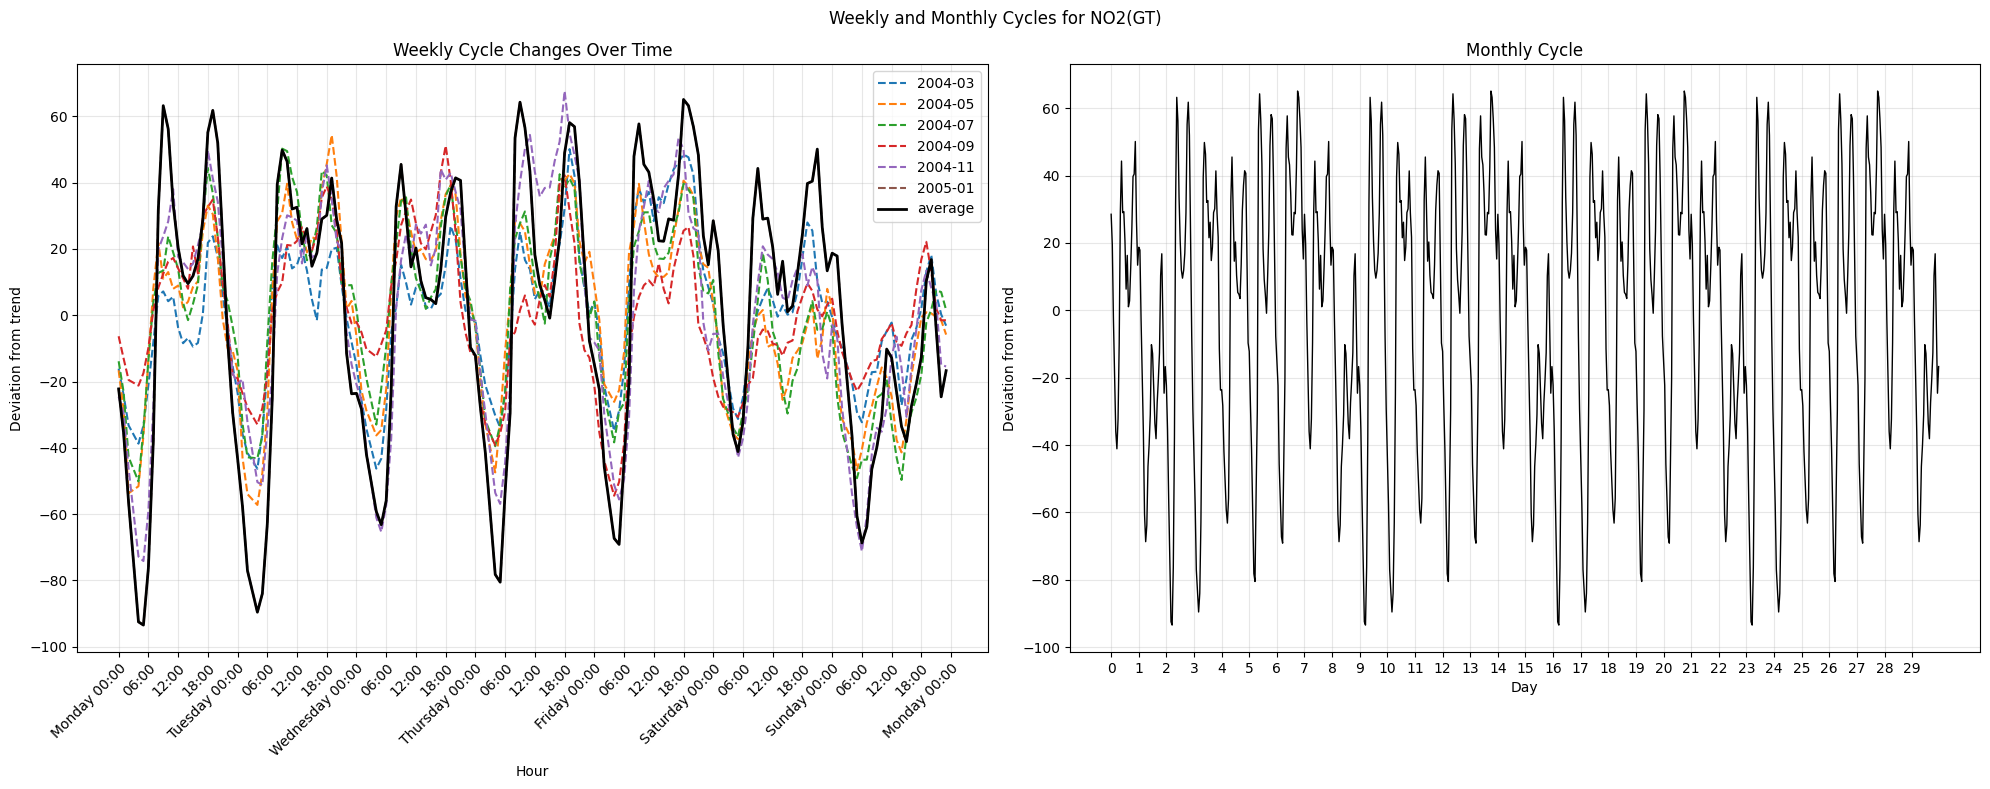

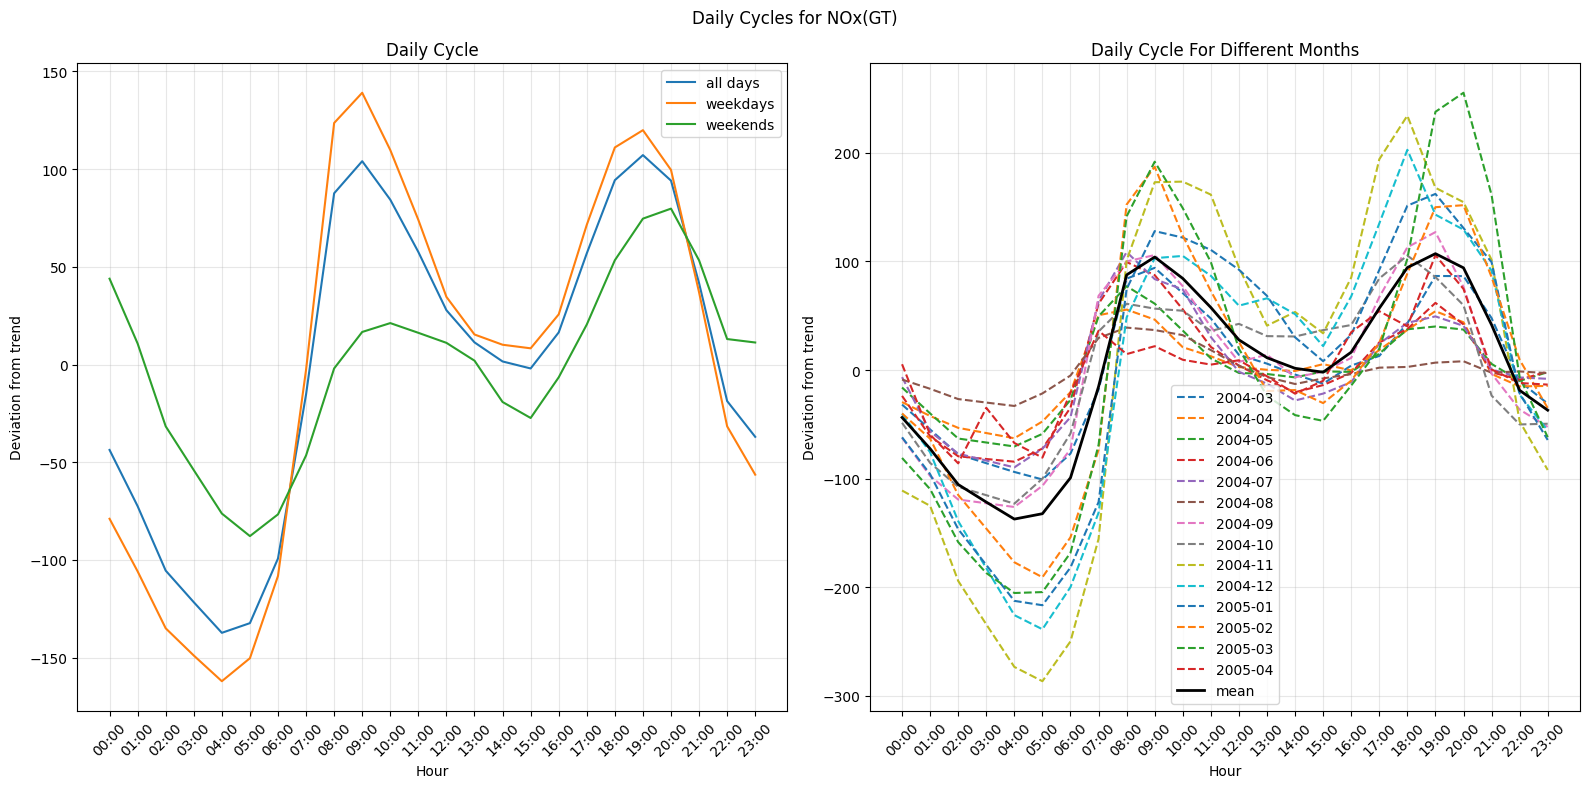

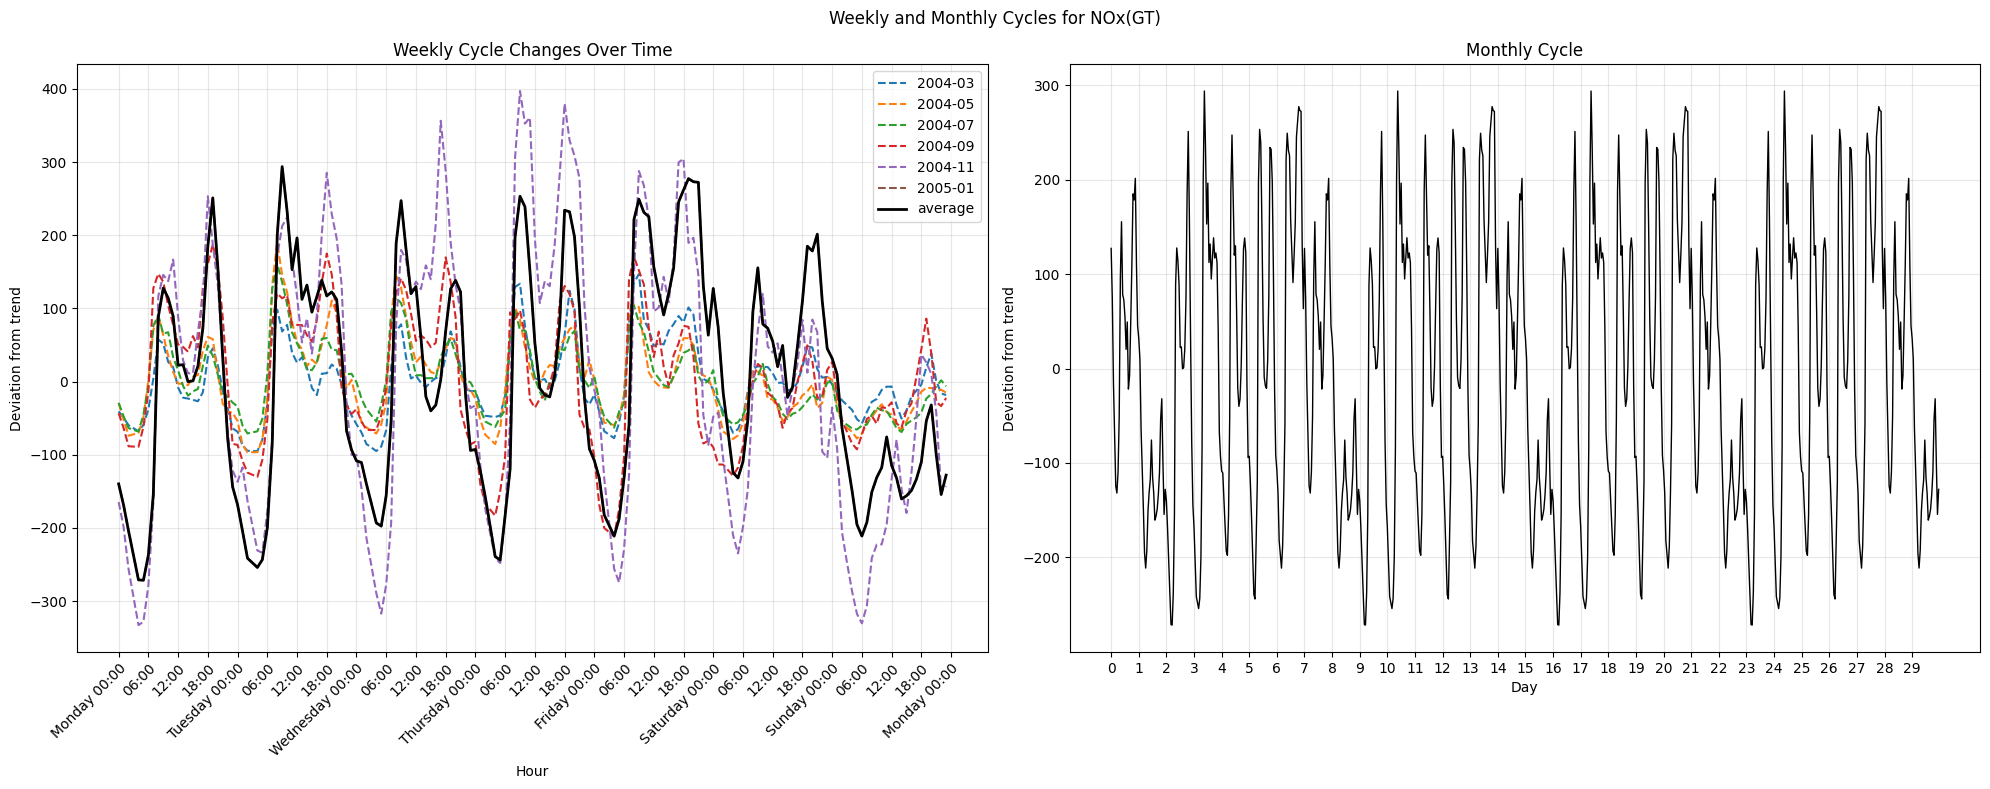

In [192]:
## Seasonal Decompositions ##

# ** CO(GT) **
def plot_seasonal(focus_column):
    fig, ax = plt.subplots(1,2, figsize=(16, 8), tight_layout=True)
    fig.suptitle(f'Daily Cycles for {focus_column}')

    # overall daily cycle, weekend daily cycle, weekday daily cycle
    plt.figure(fig)
    plt.axes(ax[0])
    period=24 # number of hours in period (24=day, 168=week)
    co_series = df_ts[focus_column].interpolate(method='time')
    decomp_full = seasonal_decompose(co_series, model='additive', period=period)
    decomp_weekday = seasonal_decompose(co_series[co_series.index.weekday < 5], model='additive', period=period)
    decomp_weekend = seasonal_decompose(co_series[co_series.index.weekday >= 5], model='additive', period=period)
    one_cycle = decomp_full.seasonal.loc['2004-03-11 00:00:00':'2004-03-11 23:00:00']            # pattern repeated, irrelevant which one we take
    one_cycle_weekday = decomp_weekday.seasonal.loc['2004-03-11 00:00:00':'2004-03-11 23:00:00'] # pattern repeated, irrelevant which one we take
    one_cycle_weekend = decomp_weekend.seasonal.loc['2004-03-13 00:00:00':'2004-03-13 23:00:00'] # pattern repeated, irrelevant which one we take
    plt.plot(np.arange(24), one_cycle, label='all days')
    plt.plot(np.arange(24), one_cycle_weekday, label='weekdays')
    plt.plot(np.arange(24), one_cycle_weekend, label='weekends')
    plt.title('Daily Cycle')
    plt.xlabel('Hour')
    plt.ylabel('Deviation from trend')
    plt.grid(True, alpha=0.3)
    plt.xticks(np.arange(24), [f'{h:02d}:00' for h in np.arange(24)], rotation=45)
    plt.legend()


    # overall daily cycle; separate months (is daily cycle relatively constant over months?)
    plt.axes(ax[1])
    def get_grouped_series(original, freq):
        monthly_series = []
        for month, group in original.groupby(pd.Grouper(freq=freq)):
            monthly_series.append((month, group.copy()))
        return monthly_series

    period=24 # number of hours in period (24=day, 168=week)
    co_series = df_ts[focus_column].interpolate(method='time')
    plt.title('Daily Cycle For Different Months')
    plt.xlabel('Hour')
    plt.ylabel('Deviation from trend')
    plt.grid(True, alpha=0.3)
    plt.xticks(np.arange(24), [f'{h:02d}:00' for h in np.arange(24)], rotation=45)
    for month, series in get_grouped_series(co_series, 'MS'):
        decomp = seasonal_decompose(series, model='additive', period=period)
        cycle_start = decomp.seasonal[decomp.seasonal.index.hour == 0].index[0]
        cycle_end = cycle_start + pd.Timedelta(hours=23)
        cycle = decomp.seasonal.loc[cycle_start:cycle_end]
        plt.plot(np.arange(24), cycle, label=month.strftime('%Y-%m'), linestyle='--')
    plt.plot(np.arange(24), one_cycle, label='mean', linewidth=2, color='black')
    plt.legend()

    fig, ax = plt.subplots(1,2, figsize=(20, 8), tight_layout=True)
    fig.suptitle(f'Weekly and Monthly Cycles for {focus_column}')
    # overall weekly cycle; subsets of data (is weekly cycle relatively constant?)
    plt.axes(ax[0])
    
    period=168 # number of hours in period (24=day, 168=week)
    co_series = df_ts[focus_column].interpolate(method='time')
    blocks=4
    plt.title('Weekly Cycle Changes Over Time')
    plt.xlabel('Hour')
    plt.ylabel('Deviation from trend')
    plt.grid(True, alpha=0.3)

    ticks = [f'{h*6%24:02d}:00' for h in np.arange(168//6+1)]
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday']
    days_ct = 0
    for i in range(len(ticks)):
        if ticks[i] == '00:00':
            ticks[i] = days[days_ct] + ' ' + ticks[i]
            days_ct += 1
            
    plt.xticks(np.arange(168//6+1)*6, ticks, rotation=45, rotation_mode='anchor', ha='right')
    for month, series in get_grouped_series(co_series, '2MS')[:-1]:
        decomp = seasonal_decompose(series, model='additive', period=period)
        cycle_start = decomp.seasonal[(decomp.seasonal.index.weekday == 0) & (decomp.seasonal.index.hour == 0)].index[0]
        cycle_end = cycle_start + pd.Timedelta(hours=167)
        cycle = decomp.seasonal.loc[cycle_start:cycle_end]
        plt.plot(np.arange(168), cycle, label=month.strftime('%Y-%m'), linestyle='--')
    decomp_full = seasonal_decompose(co_series, model='additive', period=period)
    cycle_start = decomp.seasonal[(decomp.seasonal.index.weekday == 0) & (decomp.seasonal.index.hour == 0)].index[0]
    cycle_end = cycle_start + pd.Timedelta(hours=167)
    cycle = decomp.seasonal.loc[cycle_start:cycle_end]
    plt.plot(np.arange(168), cycle, label=f'average', linewidth=2, color='black')

    plt.legend()

    # monthly cycle
    plt.axes(ax[1])
    period=24*30 
    co_series = df_ts[focus_column].interpolate(method='time')
    blocks=4
    plt.title('Monthly Cycle')
    plt.xlabel('Day')
    plt.ylabel('Deviation from trend')
    plt.grid(True, alpha=0.3)

    ticks = np.arange(30)*24
    plt.xticks(ticks, np.arange(30))
    decomp_full = seasonal_decompose(co_series, model='additive', period=period)
    cycle_start = decomp.seasonal[(decomp.seasonal.index.day == 1) & (decomp.seasonal.index.hour == 0)].index[0]
    cycle_end = cycle_start + pd.Timedelta(hours=period-1)
    cycle = decomp.seasonal.loc[cycle_start:cycle_end]
    plt.plot(np.arange(period), cycle, linewidth=1, color='black')

    # full seasonal decomposition

plot_seasonal('CO(GT)')
plot_seasonal('NO2(GT)')
plot_seasonal('NOx(GT)')

# Repeated for other pollutants and temperature





# Analysis
# If you look at the daily cycle trends relatively stable, but an outlier is 2004-08 (August), which has much less deviation. This seems to indicate
# less people are moving back and forth. Indeed, this month aligns with Italian tradition of 
# Ferragosto, which is a broad summer shutdown period, with many businesses closing for the entirety of August
# and which involves mass exodus from urban areas (50% of population). Hence less traffic movement.
# This seems to indicate we should add a 'ferragosto' flag for August, so that the model is 
# able to differentiate the anomalous monthly data.

# This is further shown by observing that on the plot_time_trends output the boxplots
# are much more contracted for august


# In the weekly cycle, there is a pronounced dip for the 2004-11 and 2004-12 on weekends.
# Not too much explanation

# Seems in addition to the ferragosto flag, for the whole month, we should add a 'pulic holidays' flag


# The monthly decomposition shows 4 regular cycles, indicating there is little week-week variation within a month, and we don't have to add a feature about it

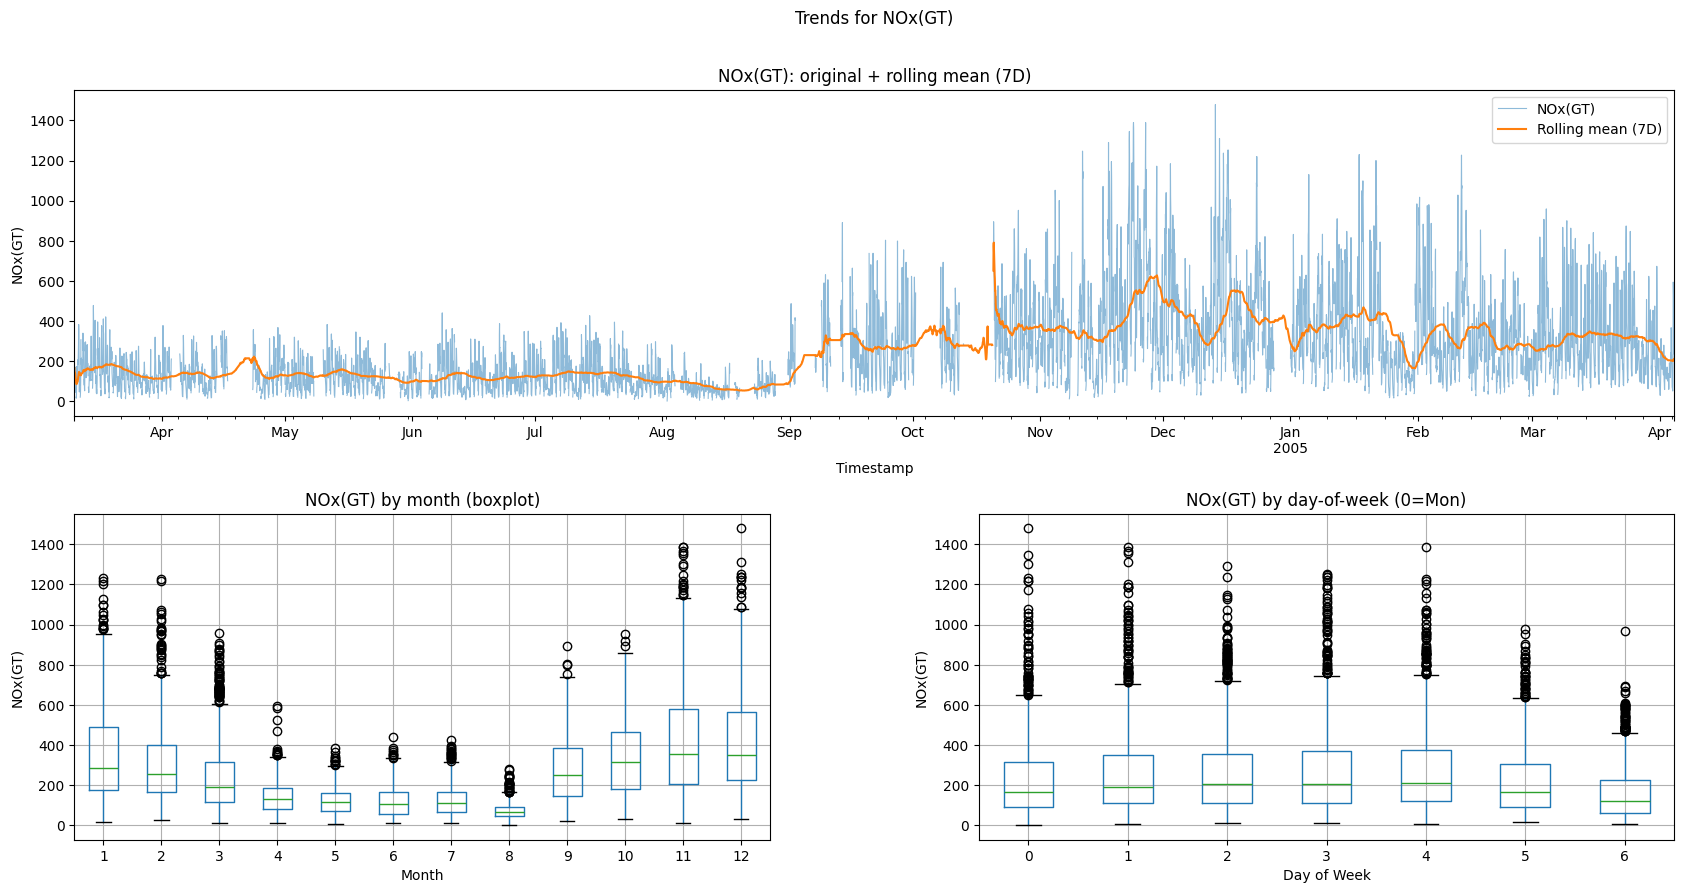

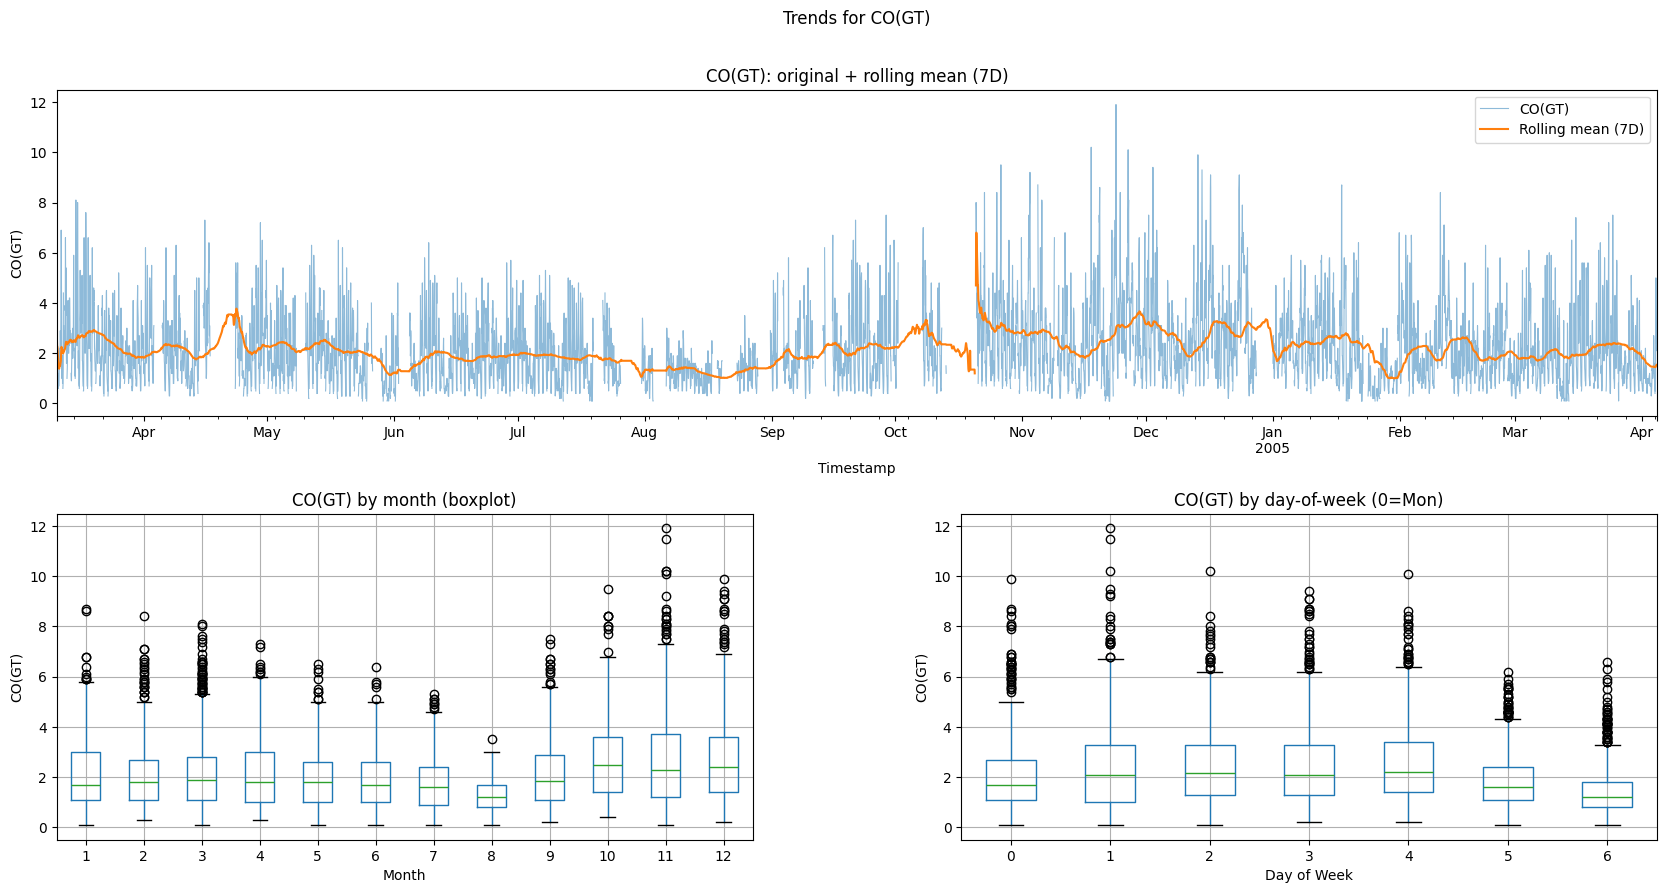

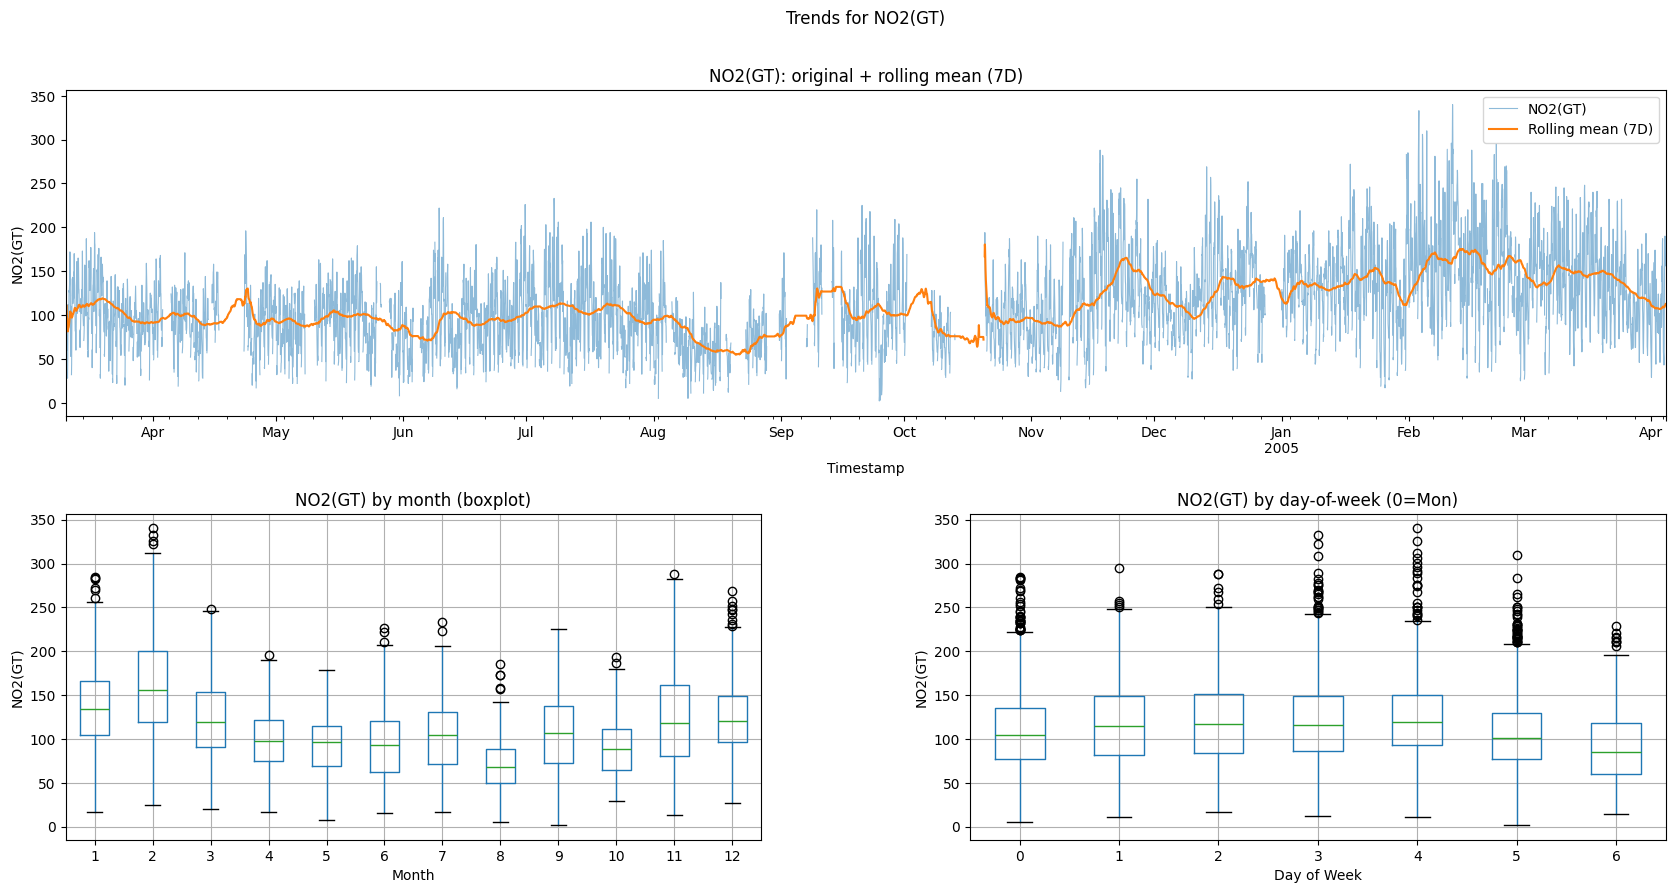

In [175]:
def plot_time_trends(focus_col):
    fig = plt.figure(figsize=(20,10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    ax = [fig.add_subplot(gs[0,:]), fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])]

    df_ts[focus_col].plot(alpha=0.5, linewidth=0.8, label=focus_col, ax=ax[0])
    roll = df_ts[focus_col].rolling('7D').mean()
    roll.plot(linewidth=1.5, label='Rolling mean (7D)', ax=ax[0])
    ax[0].legend()
    ax[0].set_title(f'{focus_col}: original + rolling mean (7D)')
    ax[0].set_ylabel(focus_col)

    tmp = df_ts[[focus_col]].copy()
    tmp['month'] = tmp.index.month
    tmp.boxplot(column=focus_col, by='month', ax=ax[1])
    ax[1].set_title(f'{focus_col} by month (boxplot)')
    ax[1].set_xlabel('Month')
    ax[1].set_ylabel(focus_col)

    tmp = df_ts[[focus_col]].copy()
    tmp['day of week'] = tmp.index.weekday
    tmp.boxplot(column=focus_col, by='day of week', ax=ax[2])
    ax[2].set_title(f'{focus_col} by day-of-week (0=Mon)')
    ax[2].set_xlabel('Day of Week')
    ax[2].set_ylabel(focus_col)
    
    fig.suptitle(f'Trends for {focus_col}')
    
plot_time_trends('NOx(GT)')
plot_time_trends('CO(GT)')
plot_time_trends('NO2(GT)')


##### Correlation Analysis

In [ ]:
## Correlation Analysis ##

corr = df_ts.corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    corr,
    mask=mask,
    fmt=".2f",
    cmap=cmap,
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title(f"Correlation Matrix")
plt.show()

# Here we can see that most of the sensor data (for both the GT and the custom sensors) have either a strong positive / negative correlation with each other. However, the sensor response all have a relatively weak correlation with the meteorological attributes.

In [ ]:
# This can be further confirmed by doing a pairplot, where we can see most of the sensor data have either a strong positive or negative correlation with each other.

sns.pairplot(df_ts)

#### Feature Preprocessing and Feature Engineering

- Aim is to create a pipeline. This should be applied to test, validation and train sets separately
- Feature Preprocessing
    - Normalise continuous features
- Feature Engineering
    - Create

In [ ]:
### ###